# De Perfecte Training Ontwerpen
## Op basis van critical power

In [110]:
import os

from athletic_pandas.models import Athlete, WorkoutDataFrame
from goldencheetahlib.client import GoldenCheetahClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

%matplotlib inline

## "Power duration model"

In [111]:
time_axis = range(1, 600)
df_power_duration = pd.DataFrame(
    dict(
        critical_power=[300]*len(time_axis),
        power_duration_curve=[20000/t + 300 for t in time_axis]
    ),
    index=time_axis
)

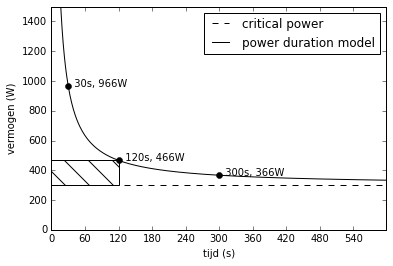

In [112]:
fig_power_duration = df_power_duration.plot(
    ylim=(0,1500),
    xticks=range(0, 600, 60),
    style=['k--', 'k-']
)
fig_power_duration.legend(["critical power", "power duration model"])
fig_power_duration.set_xlabel('tijd (s)')
fig_power_duration.set_ylabel('vermogen (W)')

maximale_inspanningen = [[30, 120, 300], [300 + 20000/t for t in [30, 120, 300]]]


fig_power_duration.plot(maximale_inspanningen[0], maximale_inspanningen[1], 'ko')
for tijd, vermogen in zip(maximale_inspanningen[0], maximale_inspanningen[1]):                                       # <--
    fig_power_duration.annotate('  {}s, {}W'.format(int(tijd), int(vermogen)), xy=(tijd, vermogen), textcoords='data')

fig_power_duration.add_patch(
    patches.Rectangle(
        (0, 300), 120, 20000/120,
        color='k',
        fill=False,
        hatch='\\'
    )
)

## "W'balance in de praktijk"

### Eerste voorbeeld: 20-minuten test

In [113]:
# De volgende code is alleen nodig als je de trainingsdata direct uit de GoldenCheetah REST API wilt halen
# gc_client = GoldenCheetahClient('Aart')
# wdf = gc_client._request_activity_data('Aart', '2017_08_08_18_04_50.json')
# wdf = wdf.set_index(wdf.index.seconds)
# wdf.athlete = Athlete(cp=315, w_prime=18000)
# wdf = wdf.assign(w_bal=np.array(wdf.w_prime_balance()))
# cropped_wdf = wdf[1700:3000]
# cropped_wdf.to_json('20_minute_test.json')
# ...anders kun je de data ook gewoon vanuit het '20_minute_test.json'-bestand laden met het code-blok hieronder.

In [114]:
wdf_20_minute = WorkoutDataFrame(pd.read_json('20_minute_test.json'))
wdf_20_minute.athlete = Athlete(cp=315, w_prime=18000)

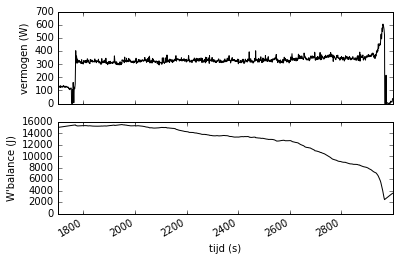

In [115]:
fig_20_minute = wdf_20_minute.loc[:, ['power', 'w_bal']].plot(
    subplots=True,
    style=['k-', 'k-'],
    legend=False,
    ylim=0
)
fig_20_minute[0].set_ylabel('vermogen (W)')
fig_20_minute[1].set_ylabel('W\'balance (J)')
fig_20_minute[1].set_xlabel('tijd (s)')

### Tweede voorbeeld: intervaltraining

In [116]:
# De volgende code is alleen nodig als je de trainingsdata direct uit de GoldenCheetah REST API wilt halen
# gc_client = GoldenCheetahClient('Aart')
# wdf_interval_workout = gc_client._request_activity_data('Aart', '2017_10_11_18_11_37.json')
# wdf_interval_workout = wdf_interval_workout.set_index(wdf_interval_workout.index.seconds)
# wdf_interval_workout.athlete = Athlete(cp=340, w_prime=20000)
# wdf_interval_workout = wdf_interval_workout.assign(w_bal=np.array(wdf_interval_workout.w_prime_balance()))
# cropped_wdf = wdf_interval_workout[1200:]
# cropped_wdf.to_json('interval_training.json')
# ...anders kun je de data ook gewoon vanuit het '20_minute_test.json'-bestand laden met het code-blok hieronder.

In [117]:
wdf_interval_workout = WorkoutDataFrame(pd.read_json('interval_training.json'))

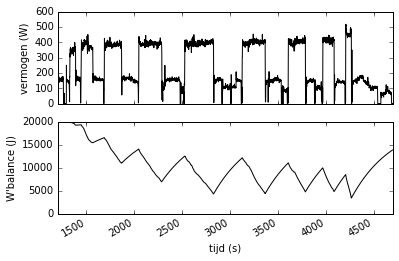

In [118]:
fig_interval_workout = wdf_interval_workout.loc[:, ['power', 'w_bal']].plot(
    subplots=True,
    style=['k-', 'k-'],
    legend=False,
    ylim=0
)
fig_interval_workout[0].set_ylabel('vermogen (W)')
fig_interval_workout[1].set_ylabel('W\'balance (J)')
fig_interval_workout[1].set_xlabel('tijd (s)')

## "Trainingen Ontwerpen"

### Casus 1

In [119]:
athlete = Athlete(cp=300, w_prime=20000)

def vermogen_casus_1(vermogen):
    warming_up = [100]*600
    interval = ([vermogen]*60 + [0]*60)*5
    rust = [0]*240
    cooling_down = [100]*600
    return warming_up + interval + rust + interval + rust + interval + cooling_down

wdf_case_1 = WorkoutDataFrame()
wdf_case_1.athlete = athlete

wdf_case_1 = wdf_case_1.assign(power=vermogen_casus_1(350))
wdf_case_1 = wdf_case_1.assign(w_bal_350=wdf_case_1.w_prime_balance())

wdf_case_1 = wdf_case_1.assign(power=vermogen_casus_1(365))
wdf_case_1 = wdf_case_1.assign(w_bal_365=wdf_case_1.w_prime_balance())

wdf_case_1 = wdf_case_1.assign(power=vermogen_casus_1(380))
wdf_case_1 = wdf_case_1.assign(w_bal_380=wdf_case_1.w_prime_balance())

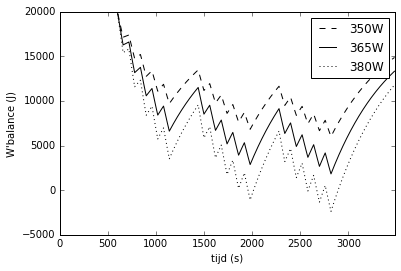

In [120]:
fig_case_1 = wdf_case_1.loc[:, ['w_bal_350', 'w_bal_365', 'w_bal_380']].plot(
    style=['k--', 'k-', 'k:']
)
fig_case_1.legend(['350W', '365W', '380W'])
fig_case_1.set_xlabel('tijd (s)')
fig_case_1.set_ylabel('W\'balance (J)')

In [121]:
for i in ['350', '365', '380']:
    min_w_bal = getattr(wdf_case_1, 'w_bal_'+i).min()
    print('Minimale W\'bal voor {vermogen}W: {min_w_bal}J ({perc}%)'.format(
        vermogen=i,
        min_w_bal=round(min_w_bal),
        perc=round(min_w_bal/wdf_case_1.athlete.w_prime*100, 1)
    ))

Minimale W'bal voor 350W: 6014.0J (30.1%)
Minimale W'bal voor 365W: 1819.0J (9.1%)
Minimale W'bal voor 380W: -2377.0J (-11.9%)


### Casus 2

In [122]:
athlete = Athlete(cp=300, w_prime=20000)
vo2_vermogen = athlete.cp + athlete.w_prime/(8*60)

def vermogen_casus_2(rust_lengte):
    warming_up = [100]*600
    interval = [vo2_vermogen]*300
    rust = [0]*rust_lengte
    cooling_down = [100]*600
    return warming_up + interval + rust + interval + rust + interval + rust + interval + cooling_down

short = 300
long = 720

wdf_case_2 = WorkoutDataFrame()
wdf_case_2.athlete = athlete
wdf_case_2 = wdf_case_2.assign(power=vermogen_casus_2(short) + [0.]*(long-short)*3)
wdf_case_2 = wdf_case_2.assign(w_bal_5m_rust=wdf_case_2.w_prime_balance())

wdf_case_2 = wdf_case_2.assign(power=vermogen_casus_2(long))
wdf_case_2 = wdf_case_2.assign(w_bal_12m_rust=wdf_case_2.w_prime_balance())

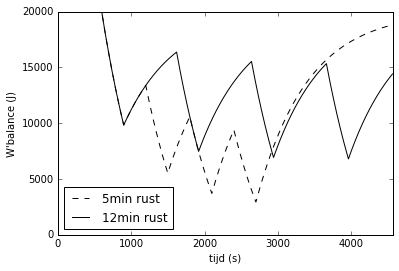

In [123]:
fig_case_2 = wdf_case_2.loc[:, ['w_bal_5m_rust', 'w_bal_12m_rust']].plot(
    ylim=0,
    style=['k--', 'k-']
)
fig_case_2.legend(['5min rust', '12min rust'], loc=3)
fig_case_2.set_xlabel('tijd (s)')
fig_case_2.set_ylabel('W\'balance (J)')

In [124]:
w_bal_voor_tweede_5m = wdf_case_2.w_bal_5m_rust[600 + 300 + 300]
print('W\'bal voorafgaand aan tweede interval bij 5 min rust: {w_bal}J ({perc}%)'.format(
        w_bal=round(w_bal_voor_tweede_5m),
        perc=round(w_bal_voor_tweede_5m/wdf_case_2.athlete.w_prime*100)
))

w_bal_voor_laatste_12m = wdf_case_2.w_bal_12m_rust[600 + 3*300 + 3*720]
print('W\'bal voorafgaand aan laatste interval bij 12 min rust: {w_bal}J ({perc}%)'.format(
        w_bal=round(w_bal_voor_laatste_12m),
        perc=round(w_bal_voor_laatste_12m/wdf_case_2.athlete.w_prime*100)
))

W'bal voorafgaand aan tweede interval bij 5 min rust: 13352.0J (67.0%)
W'bal voorafgaand aan laatste interval bij 12 min rust: 15305.0J (77.0%)


### Casus 3

In [125]:
athlete = Athlete(cp=300, w_prime=20000)

def vermogen_casus_3(rust_lengte):
    warming_up = [100]*600
    interval = [athlete.cp*1.40]*60
    rust = [0]*rust_lengte
    cooling_down = [100]*600
    return warming_up + (interval + rust)*8 + cooling_down

short = 120
middle = 240
long = 300

wdf_case_3 = WorkoutDataFrame()
wdf_case_3.athlete = athlete
wdf_case_3 = wdf_case_3.assign(power=vermogen_casus_3(short) + [0.]*((long-short)*8))
wdf_case_3 = wdf_case_3.assign(w_bal_120=wdf_case_3.w_prime_balance())

wdf_case_3 = wdf_case_3.assign(power=vermogen_casus_3(middle) + [0.]*((long-middle)*8))
wdf_case_3 = wdf_case_3.assign(w_bal_240=wdf_case_3.w_prime_balance())

wdf_case_3 = wdf_case_3.assign(power=vermogen_casus_3(long))
wdf_case_3 = wdf_case_3.assign(w_bal_300=wdf_case_3.w_prime_balance())

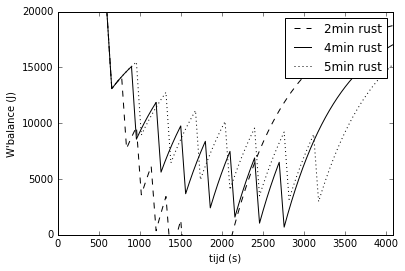

In [129]:
fig_case_3 = wdf_case_3.loc[:, ['w_bal_120', 'w_bal_240', 'w_bal_300']].plot(
    ylim=0,
    style=['k--', 'k-', 'k:']
)
fig_case_3.legend(['2min rust', '4min rust', '5min rust'])
fig_case_3.set_xlabel('tijd (s)')
fig_case_3.set_ylabel('W\'balance (J)')

In [127]:
for i in ['120', '240', '300']:
    min_w_bal = getattr(wdf_case_3, 'w_bal_'+i).min()
    print('Minimale W\'bal voor {rust} min rust: {min_w_bal}J ({perc}%)'.format(
        rust=int(int(i)/60),
        min_w_bal=round(min_w_bal),
        perc=round(min_w_bal/wdf_case_3.athlete.w_prime*100)
    ))

Minimale W'bal voor 2 min rust: -6729.0J (-34.0%)
Minimale W'bal voor 4 min rust: 689.0J (3.0%)
Minimale W'bal voor 5 min rust: 2979.0J (15.0%)


# Afbeeldingen exporteren

In [128]:
figures = [fig_power_duration, fig_20_minute, fig_interval_workout, fig_case_1, fig_case_2, fig_case_3]
figure_names = ['figuur 1 - power duration', 'figuur 2 - 20 minute', 'figuur 3 - interval workout', 'figuur 4 - case 1', 'figuur 5 - case 2', 'figuur 6 - case 3']
for fig, name in zip(figures, figure_names):
    if hasattr(fig, 'savefig'):
        f = fig
    elif isinstance(fig, np.ndarray):
        f = fig[0].get_figure()
    else:
        f = fig.get_figure()

    f.savefig('.temporary.tiff', dpi=600)
    Image.open('.temporary.tiff').convert("L").save(name + '.jpg', 'JPEG', dpi=(600, 600))
    os.remove('.temporary.tiff')